# dSTRF
Code from Matt https://github.com/NeuroTheoryUMD/mattjac/blob/4b9a97f124a6fa22b6e6754b7519e00274ad03e3/v1/lib/predict.py

December 2, 2025

In [1]:
%load_ext autoreload
%autoreload 2

#import predict
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from torch.func import jacrev
from imports import *
import mattjac.v1.lib.predict as predict
datadir, dirname, device, device0 = init_vars('simcloud', GPU=0)

2026 February 3: ifernand running on sc
Device assigned: cuda:0
Loaded additional packages:
  scd spu readout_fit BC 
Datadir: /data/Antolik/
Dirname: /home/ifernand/


In [2]:
cnn = NDN.load_model('models/width_test_12-23-25/2026-01-01_04-54-07_NDN491_Q5_R1_width_16-12-12_GQMmu_seed100.ndn')
cnn.block_sample = True
cnn.loss_module.unit_weighting = True
print(cnn.info())
print(cnn.list_parameters())

NDN poissonL, output net #1:
  0 scaffold3d: Input = 'stim' [1, 40, 40, 1], Scaffold levels = 1 3 4
    0 STconv10:   2 (i0)  [relu] w9  NBH	{'d2t': 0.0001, 'd2x': 1.0, 'center': 0.05}
    1  oriconv:  16 (i8)  [relu] w19 NBH	{'d2x': 0.003, 'center': 1e-11}
    2   normal:   1 (i0)  [lin]   		
    3  oriconv:  12 (i6)  [relu] w1  NB		
    4  oriconv:  12 (i6)  [relu] w1  NB		
  1 readout: Input = ffnet 0 [40, 40, 40, 6]
    0 readQsmp: 1491 (i0)  [soft]  bias+	{'max': 0.001}
None
Network 0:
  Layer 0:
      weight: torch.Size([810, 2])
  Layer 1:
      weight: torch.Size([722, 16])
  Layer 2:
      NOT FIT: weight: torch.Size([1, 1])
  Layer 3:
      weight: torch.Size([16, 12])
  Layer 4:
      weight: torch.Size([12, 12])
Network 1:
  Layer 0:
      weight: torch.Size([40, 1491])
      bias: torch.Size([1491])
      mu: torch.Size([1491, 2])
      sigma: torch.Size([1491, 1])
      Qmu: torch.Size([1491, 1])
      Qsigma: torch.Size([1491, 1])
None


In [3]:
start    = time()
data     = scd.SimCloudData(down_sample=3, num_lags=11, block_len=100)
end      = time()
print('CPU Time', end-start, 'sec')

CPU Time 54.091912508010864 sec


In [5]:
NC = data.NC
NT = data.NT
block_len = data.block_len
NB = data.NB
L  = data.stim_dims[1]
print('Number of cells', NC)
print('Number of time points', NT)
print('Block length:', block_len)
print('Number of blocks:', NB)
print('L =', L)

Number of cells 1491
Number of time points 480000
Block length: 100
Number of blocks: 4800
L = 40


In [6]:
def func0(X):
    return cnn.networks[0].layers[0](X)

In [7]:
X0 = data[0]['stim']
X0.shape

torch.Size([100, 1600])

In [8]:
Y0 = func0(X0[:10,:])
Y0.shape

torch.Size([10, 3200])

In [9]:
jacobian0 = jacrev(func0)(X0[:10,:])
jacobian0.shape

torch.Size([10, 3200, 10, 1600])

In [10]:
jacobian0 = jacobian0[0,:,:,:].reshape((1,(2*L*L),(10*L*L)))
jacobian0.shape

torch.Size([1, 3200, 16000])

In [11]:
def func1(X):
    return cnn.networks[0].layers[1](X)

In [13]:
X1 = Y0[0,:].reshape((1,(2*L*L))).clone().detach()
X1.shape

torch.Size([1, 3200])

In [14]:
Y1 = func1(X1)
Y1.shape

torch.Size([1, 153600])

In [15]:
jacobian1 = jacrev(func1)(X1)
jacobian1.shape

torch.Size([1, 153600, 1, 3200])

In [16]:
def func2(X):
    return cnn.networks[0].layers[2](X)

In [17]:
X2 = Y1.clone().detach()
X2.shape

torch.Size([1, 153600])

In [18]:
Y2 = func2(X2)
Y2.shape

torch.Size([1, 153600])

In [19]:
jacobian2 = jacrev(func2)(X2)
jacobian2.shape

torch.Size([1, 153600, 1, 153600])

In [20]:
def func3(X):
    return cnn.networks[0].layers[3](X)

In [21]:
X3 = Y2.clone().detach()
X3.shape

torch.Size([1, 153600])

In [22]:
Y3 = func3(X3)
Y3.shape

torch.Size([1, 115200])

In [ ]:
jacobian3 = jacrev(func3)(X3)
jacobian3.shape

In [16]:
def func4(X):
    return cnn.networks[0].layers[4](X)

In [17]:
X4 = Y3.clone().detach()
X4.shape

torch.Size([1, 153600])

In [18]:
Y2 = func(X4)
Y2.shape

torch.Size([1, 153600])

In [19]:
jacobian2 = jacrev(func2)(X2)
jacobian2.shape

torch.Size([1, 153600, 1, 153600])

In [6]:
robs = data[:]['robs'].detach().cpu().numpy()
dfs = data[:]['dfs'].detach().cpu().numpy()
robs.shape, dfs.shape

((480000, 1491), (480000, 1491))

In [6]:
gdata = GenericDataset( {'stim': data[:]['stim'], 
                        'robs': data[:]['robs'], 
                        'dfs':data[:]['dfs']}, device=device0)

In [11]:
neurons = [0] #, 656, 1025, 1312]

spike_pred_times_neurons = {neuron: [] for neuron in neurons}
for nt in range(2):
    print('### Time', nt)
    results_3iter = predict.predict(cnn, dataset=data[nt], calc_jacobian=False, verbose=False)
    robs = data[nt]['robs'].detach().cpu().numpy()
    dfs = data[nt]['dfs'].detach().cpu().numpy()
    for neuron in neurons:
        print('--> Neuron', neuron)
        # find times when the neuron spikes and the prediction is above a threshold at the same time
        spike_times = np.where(robs[:,neuron]*dfs[:,neuron] > 0)[0]
        pred_times = np.where(results_3iter.pred[:,neuron] > 0.8)[0]
        spike_pred_times = np.intersect1d(spike_times, pred_times) + (block_len*nt)
        spike_pred_times_neurons[neuron].append(spike_pred_times)
        
        print(spike_pred_times)
    print('=======')

for neuron in neurons:
    spike_pred_times_neurons[neuron] = np.concatenate(spike_pred_times_neurons[neuron])

### Time 0
--> Neuron 0
[ 15  16  17  39 122 164 184 213 231 232 252 292 300 318 342 363 386 441
 522 712 723 724 757 789 802 803 953]
### Time 1
--> Neuron 0
[1014 1026 1053 1054 1108 1143 1193 1194 1208 1264 1265 1285 1293 1331
 1347 1349 1382 1384 1392 1420 1506 1523 1535 1579 1611 1612 1674 1795
 1902 1903 1923 1998]


In [12]:
pred_cell0 = cnn(gdata[spike_pred_times_neurons[neuron]])
pred_cell0.shape

torch.Size([59, 1491])

In [13]:
robs = data[:2]['robs'].detach().cpu().numpy()
dfs = data[:2]['dfs'].detach().cpu().numpy()

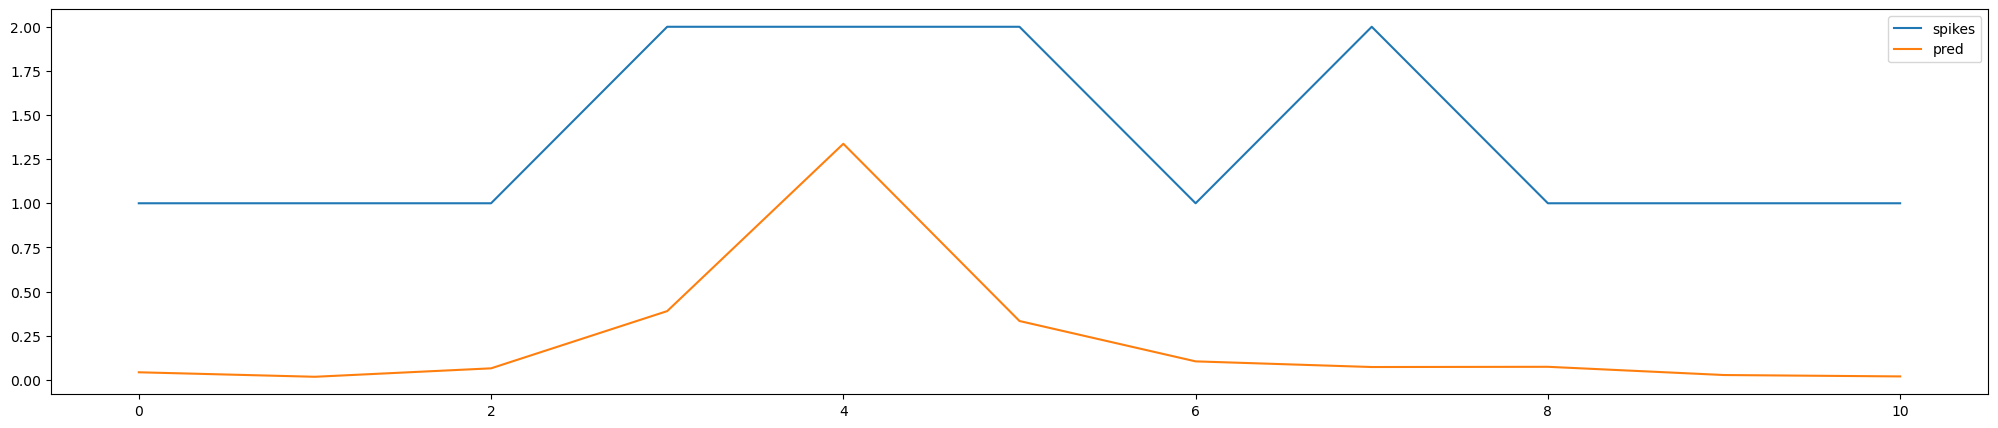

In [14]:
neuron = 0
start = 8
end = 19

fig = plt.figure(figsize=(25,5))
plt.plot(robs[spike_pred_times_neurons[neuron][start:end], neuron]*dfs[spike_pred_times_neurons[neuron][start:end], neuron], label='spikes')
plt.plot(pred_cell0[start:end, neuron].detach().numpy(), label='pred')
plt.legend()
plt.show()

In [15]:
def func(X):
    return cnn.networks[0].layers[0](X)

In [19]:
cnn.networks[0].layers[0].input_dims

[1, 40, 40, 1]

In [16]:
X = gdata[spike_pred_times_neurons[neuron][start:end]]['stim']
X.shape

torch.Size([11, 1600])

In [17]:
Y = func(X)
Y.shape

torch.Size([11, 3200])

In [18]:
jacobian = jacrev(func)(X)
jacobian.shape

torch.Size([11, 3200, 11, 1600])

In [15]:
layer_jacobians = []
for i in range(5):
    jacobian = jacrev(func)(X[i,:])
    layer_jacobians.append(jacobian)

In [17]:
layer_jacobians[0].shape

torch.Size([1, 3200, 1600])

In [18]:
stacked_jacobians = torch.vstack(layer_jacobians)
stacked_jacobians.shape

torch.Size([5, 3200, 1600])

In [21]:
stacked_jacobians.reshape(stacked_jacobians.shape[0], cnn.networks[0].layers[0].num_filters, data.stim_dims[1], cnn.networks[0].layers[0].num_lags, -1).shape

torch.Size([5, 2, 40, 10, 6400])

In [14]:
cnn.networks[0].layers[0].num_filters, cnn.networks[0].layers[0].num_lags, 

(2, 10)

In [ ]:
X = gdata[spike_pred_times_neurons[neuron][start:end]]['stim']
prev_out = []
jacobian_list = []
# core jacobian
for ll in range(4):
    def func(X):
        return cnn.networks[0].layers[ll](X)
    layer_jacobians = []
    for i in range(end-start):
        if ll == 0:
            jacobian = jacrev(func)(X[i,:])
        else:
            jacobian = jacrev(func)(prev_out[ll-1][i,:])
        layer_jacobians.append(jacobian)
    stacked_jacobians = torch.vstack(layer_jacobians)
    jacobian_list.append(stacked_jacobians)
    print('layer',ll,'jacobian computed')

    if ll == 0:
        prev_out.append(func(X))
    else:
        prev_out.append(func(prev_out[ll-1]))
    print(prev_out[ll].shape)

layer 0 jacobian computed
torch.Size([11, 3200])


In [ ]:
results_cell0 = predict.predict(cnn, dataset=gdata[spike_pred_times_neurons[neuron][start:end]], calc_jacobian=True, verbose=True)

num_inps 5
prev_output shape torch.Size([5, 1600]) ni 0 scaffold3d li 0


 20%|█████████                                    | 1/5 [00:01<00:06,  1.62s/it]

Jacobian shape: torch.Size([1, 3200, 1600])


 40%|██████████████████                           | 2/5 [00:02<00:04,  1.36s/it]

Jacobian shape: torch.Size([1, 3200, 1600])


 60%|███████████████████████████                  | 3/5 [00:04<00:02,  1.31s/it]

Jacobian shape: torch.Size([1, 3200, 1600])


 80%|████████████████████████████████████         | 4/5 [00:05<00:01,  1.28s/it]

Jacobian shape: torch.Size([1, 3200, 1600])


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Jacobian shape: torch.Size([1, 3200, 1600])
torch.Size([5, 1600]) --> torch.Size([5, 3200])
prev_output shape torch.Size([5, 3200]) ni 0 scaffold3d li 1


  0%|                                                     | 0/5 [00:00<?, ?it/s]

In [8]:
results_cell0 = predict.predict(cnn, dataset=gdata[:2], calc_jacobian=True, verbose=True)

num_inps 2
prev_output shape torch.Size([2, 1600]) ni 0 scaffold3d li 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.86s/it]


torch.Size([2, 1600]) --> torch.Size([2, 3200])
prev_output shape torch.Size([2, 3200]) ni 0 scaffold3d li 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [07:44<00:00, 232.41s/it]


torch.Size([2, 3200]) --> torch.Size([2, 153600])
prev_output shape torch.Size([2, 153600]) ni 0 scaffold3d li 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [08:22<00:00, 251.23s/it]


torch.Size([2, 153600]) --> torch.Size([2, 153600])
prev_output shape torch.Size([2, 153600]) ni 0 scaffold3d li 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [07:53<00:00, 236.82s/it]


torch.Size([2, 153600]) --> torch.Size([2, 115200])
prev_output shape torch.Size([2, 115200]) ni 0 scaffold3d li 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [08:53<00:00, 266.60s/it]


torch.Size([2, 115200]) --> torch.Size([2, 115200])
prev_output shape torch.Size([2, 115200]) ni 1 readout li 0


  0%|                                                                                                                   | 0/2 [00:00<?, ?it/s]


RuntimeError: shape '[-1, 40, 40, 40, 6]' is invalid for input of size 115200

In [36]:
cnn.networks[1].network_type

'readout'

In [ ]:
results_cell0.jacobian.shape

In [ ]:
plot.imagesc(results_cell0.jacobian[0,0,neuron,:].reshape(36,14), cmap='gray_r', origin='lower')
plt.title('DSTRF', fontsize=16)

In [14]:
results.jacobian

[]

In [9]:
imagesc(results_.jacobian[timepoint,0,neuron,:].reshape(36,14), cmap='gray_r', origin='lower')

[1, 40, 40, 1]